# Exam 2022

In [5]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.stats import norm 
from scipy import stats
import itertools
from iminuit import Minuit   
from scipy.optimize import minimize
import sys  
from importlib import reload
from scipy import interpolate
import copy
import pandas as pd
import math

# Standard libraires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import ultranest
from ultranest.plot import cornerplot
from ultranest.plot import PredictionBand


# external libraries
sys.path.append('../') 
import AdvAppStatFunctions as aas

# setting for plotting
from matplotlib.patches import ConnectionPatch
import seaborn as sns
plt.style.use('seaborn-white')
sns.set_style('white', {'legend.frameon':True})
plt.rcParams['font.size'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.labelsize'] = 14
sns.set_palette("colorblind")
color = sns.color_palette("colorblind")

# Problem 2a

Quantify whether the data is spherically isotropically
distributed

A spherically isotropic distribution is uniform in the azimuth angle
from 0 to 2π, and uniform in cos(zenith angle) from -1 to 1

• Hint: you can use Monte Carlo generated pseudo-experiments to produce a teststatistic distribution of a spherically isotropic distribution.

• Hint: isotropically distributed means ‘uniform’ simultaneously in azimuth and
cos(zenith).

## Parsing data

In [7]:
data_prob2 = np.genfromtxt('Data/Exam_2022_Problem2.txt', skip_header=1)
azi = data_prob2[:,0]
zen = data_prob2[:,1]

## Plotting the data 

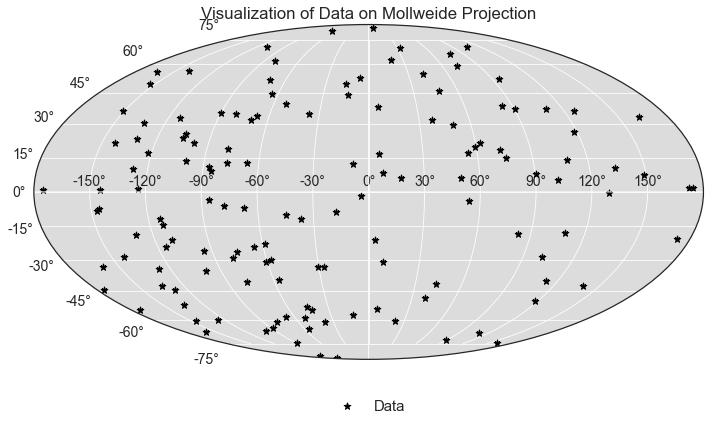

In [11]:
# Plot data
fig, ax = plt.subplots(figsize=(12,12), subplot_kw={'projection': 'mollweide'})
aas.mollweide_projection(azi, zen, ax)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), prop={'size':15});

### Sample isotrpoic data

Isotropic data is uniformly distributed both in the azimuth angle with range (0,2pi) and in cos(zenith angle) with range (-1,1). We will randomly sample as many points as is in the data set from these distributions.

In [5]:
# Sample from distributions
np.random.seed(1)
N_points = len(data_prob2)
MC_azi, MC_zen = aas.sample_isotropic_data(N_points)

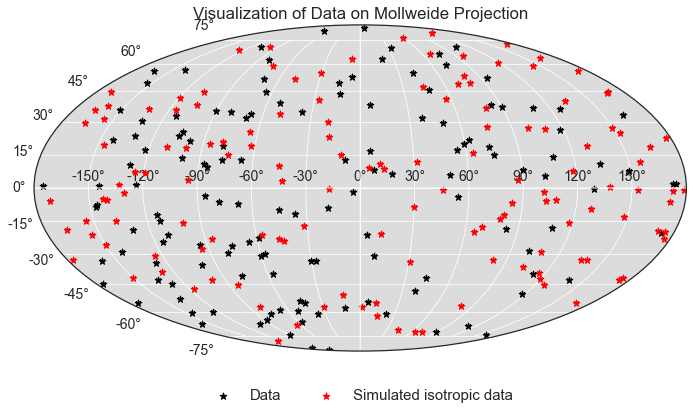

In [6]:
# Plot data and simulated sample
fig, ax = plt.subplots(figsize=(12,6), subplot_kw={'projection': 'mollweide'})

# Plot data
aas.mollweide_projection(azi, zen, ax)

# Plot simulated sample
ax.scatter(MC_azi-np.pi, -MC_zen+np.pi/2, marker='*', color='r', s=50, zorder=2, label='Simulated isotropic data')
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2, prop={'size':15});

### Two Point Auto-Correlation Function

We now calculate the two point auto-correlation function, so we can compare them with a KS-test later.

In [7]:
x, y, y_pred = aas.two_point_func(azi, zen)
MC_x, MC_y, MC_y_pred = aas.two_point_func(MC_azi, MC_zen)

### KS-test

In [8]:
KS_H0 = aas.KS_test(y, y_pred)
KS_MC_H0 = aas.KS_test(MC_y, MC_y_pred)
print(KS_H0, KS_MC_H0)

0.022574309673822568 0.012473428533127273


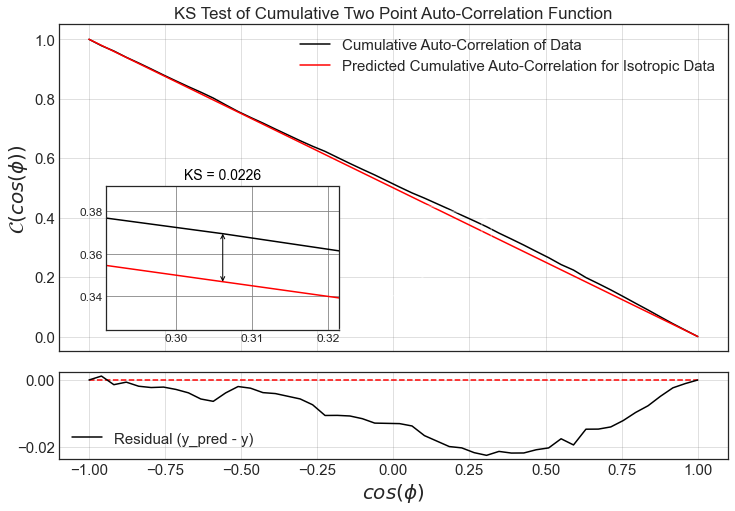

In [9]:
fig, ax = plt.subplots(nrows=2, figsize=(12,8), sharex=True, gridspec_kw = {'height_ratios': [1.5, 0.4], 'hspace': 0.1})
aas.KS_plot(x, y, y_pred, MC_x, MC_y, MC_y_pred, fig, ax)

### P-value from pseudo-experiments

The idea is now to simulate many isotropiccaly distributed data, and find their ks value by comparing it to the predicted isotropic. We can then calculate a p value from the distribution of ks-value, that tells us the likelihood of obtaining the KS test of 0.0163 that we got.

In [10]:
reload(aas);

In [11]:
# We produce 5000 experiments
N_experiments = 5000
KS_experiments = aas.sample_KS(N_experiments, len(azi))

  0%|          | 0/5000 [00:00<?, ?it/s]

In [14]:
# Calculate the p-value (integrating number of events above cut divided by events below)
p_iso = aas.compute_p_val(KS_H0, KS_experiments)
print(f'p-value for isotropic: {p_iso}')

p-value for isotropic: 0.0044


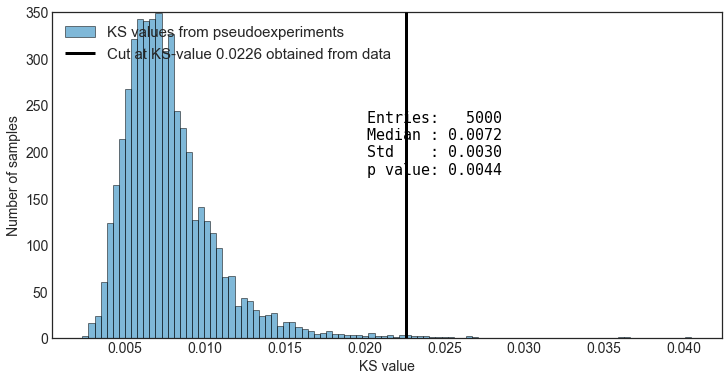

In [17]:
# Create figure to demonstrate the finding of the p-value
fig, ax = plt.subplots(figsize=(12,6))
#ax.set_facecolor('gainsboro')
#ax.grid(color='white')

# Plot distribution of KS-values
bins_arr = np.arange(0,0.030,0.0005)
ax.hist(KS_experiments, color=color[0], ec='k', alpha=0.5, bins=100, zorder=2,
        label=f'KS values from pseudoexperiments')

# Plot the cut
ax.vlines(KS_H0, 0, 350, color='k', linewidth=3, zorder=3,
          label=f'Cut at KS-value {KS_H0:.4f} obtained from data')

# Display the pvalue and other specs
d = {r'Entries:': len(KS_experiments),
     r'Median :': np.median(KS_experiments),
     r'Std    :': np.std(KS_experiments),
     r'p value:': p_iso
    }
text = aas.nice_string_output(d, extra_spacing=1, decimals=4)
aas.add_text_to_ax(0.47, 0.7, text, ax, fontsize=15, color='k')


plt.ylim(0,350)
ax.legend(loc='upper left', prop={'size':15})
ax.set(xlabel='KS value', ylabel='Number of samples')


#if SaveFig:
#    plt.tight_layout()
#    plt.savefig('Plots/2a_4.pdf')
    
plt.show()

# Problem 2b

Test whether the data fits the two following alternative
hypotheses better than the isotropic hypothesis:

• Hypothesis A: That 20% of the total sample is uniformly distributed
in azimuth over the range {0.225π, 0.725π} and uniformly distributed
in zenith over the range {0.30π, 1π}, and the remaining 80% is fully
isotropic

• Hypothesis B: That 15% of the total sample is uniformly distributed
in azimuth over the range {0π, 1π} and uniformly distributed in zenith
over the range {0.5π, 1π}, and the remaining 85% is fully isotropic.

In [21]:
# Define a function to simulate data from hypothesis A
def sample_HA(seed, N_points=len(data_prob2)):
    
    # Set seed
    np.random.seed(seed)
    
    # Get number of points to sample uniformly in specified range
    N_uniform = int(0.2 * N_points)
    
    # Define uniform range
    uni_azim_range = (0.225*np.pi, 0.725*np.pi)
    uni_zeni_range = (0.30*np.pi, 1*np.pi)
    
    # Sample from uniform distributions within range
    uni_azim = np.random.uniform(*uni_azim_range, size=N_uniform)
    uni_zeni = np.random.uniform(*uni_zeni_range, size=N_uniform)
    
    # Sample the rest isotropically
    iso_azim = np.random.uniform(low=0, high=2*np.pi, size=N_points-N_uniform)
    iso_cos_zeni = np.random.uniform(low=-1, high=1, size=N_points-N_uniform)
    iso_zeni = np.arccos(iso_cos_zeni)
    
    # Concatenate arrays
    MC_azim = np.concatenate([uni_azim, iso_azim])
    MC_zeni = np.concatenate([uni_zeni, iso_zeni])
    
    return MC_azim, MC_zeni

# Define a function to simulate data from hypothesis B
def sample_HB(seed, N_points=len(data_prob2)):
    
    # Set seed
    np.random.seed(seed)
    
    # Get number of points to sample uniformly in specified range
    N_uniform = int(0.15 * N_points)
    
    # Define uniform range
    uni_azim_range = (0*np.pi, 1*np.pi)
    uni_zeni_range = (0.5*np.pi, 1*np.pi)
    
    # Sample from uniform distributions within range
    uni_azim = np.random.uniform(*uni_azim_range, size=N_uniform)
    uni_zeni = np.random.uniform(*uni_zeni_range, size=N_uniform)
    
    # Sample the rest isotropically
    iso_azim = np.random.uniform(low=0, high=2*np.pi, size=N_points-N_uniform)
    iso_cos_zeni = np.random.uniform(low=-1, high=1, size=N_points-N_uniform)
    iso_zeni = np.arccos(iso_cos_zeni)
    
    # Concatenate arrays
    MC_azim = np.concatenate([uni_azim, iso_azim])
    MC_zeni = np.concatenate([uni_zeni, iso_zeni])
    
    return MC_azim, MC_zeni

# Define a function that calculates the KS_test for many data sets simmulated from HA
def sample_KS_HA(N_samples, N_points):
    
    # Array to store KS val in
    KS_arr = []
    
    # Loop over samples
    print('------- SAMPLING HA -------')
    for i in tqdm(range(N_samples)):
    
        # Produce sample of isotropic data
        MC_azim, MC_zeni = sample_HA(i*100, N_points)
        
        # Get two point correlation func
        x, y, y_pred = aas.two_point_func(MC_azim, MC_zeni)
        
        # Get KS val
        KS_val = np.max( np.abs(y_pred-y) )
        KS_arr.append(KS_val)
        
    return KS_arr

# Define a function that calculates the KS_test for many data sets simmulated from HB
def sample_KS_HB(N_samples, N_points):
    
    # Array to store KS val in
    KS_arr = []
    
    # Loop over samples
    print('------- SAMPLING HB -------')
    for i in tqdm(range(N_samples)):
    
        # Produce sample of isotropic data
        MC_azim, MC_zeni = sample_HB(i*100, N_points)
        
        # Get two point correlation func
        x, y, y_pred = aas.two_point_func(MC_azim, MC_zeni)
        
        # Get KS val
        KS_val = np.max( np.abs(y_pred-y) )
        KS_arr.append(KS_val)
        
    return KS_arr

In [22]:
# We produce 5000 experiments for each of the hypothesis (we already sampled isotropically)
N_experiments = 5000
KS_HA_experiments = sample_KS_HA(N_experiments, len(azi))
KS_HB_experiments = sample_KS_HB(N_experiments, len(azi))

------- SAMPLING HA -------


  0%|          | 0/5000 [00:00<?, ?it/s]

------- SAMPLING HB -------


  0%|          | 0/5000 [00:00<?, ?it/s]

In [24]:
# Calculate p-values with respect to isotropic data
p_iso_HA = aas.compute_p_val(np.median(KS_HA_experiments), KS_experiments)
p_iso_HB = aas.compute_p_val(np.median(KS_HB_experiments), KS_experiments)
print('is HA hypothesis compatible with isotropic sampling H0?')
print('p_iso_HA:', p_iso_HA)
print('is HB hypothesis compatible with isotropic sampling H0?')
print('p_iso_HB:', p_iso_HB)

print('------------------')

# Calculate p-values with respect to the real data
p_data_HA = aas.compute_p_val(KS_H0, KS_HA_experiments)
p_data_HB = aas.compute_p_val(KS_H0, KS_HB_experiments)
print('is HA hypothesis compatible with the data?')
print('p_data_HA:', p_data_HA)
print('is HB hypothesis compatible with the data')
print('p_data_HB:', p_data_HB)

is HA hypothesis compatible with isotropic sampling H0?
p_iso_HA: 0.0134
is HB hypothesis compatible with isotropic sampling H0?
p_iso_HB: 0.0852
------------------
is HA hypothesis compatible with the data?
p_data_HA: 0.3274
is HB hypothesis compatible with the data
p_data_HB: 0.1144


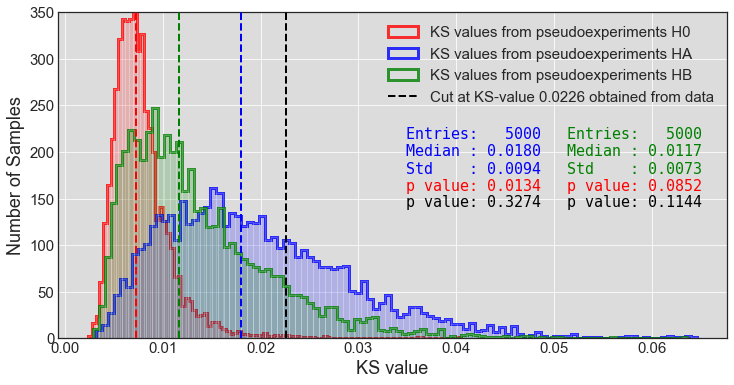

In [26]:
# Plot it all together

# Create figure to demonstrate the finding of the p-value
fig, ax = plt.subplots(figsize=(12,6))
ax.set_facecolor('gainsboro')
ax.grid(color='white')

# Plot distribution of KS-values
bins_arr = np.arange(0,0.035,0.0005)
ax.hist(KS_experiments, color='red', histtype='step', alpha=0.8, linewidth=3, bins=100, zorder=2,
        label=f'KS values from pseudoexperiments H0')
ax.hist(KS_experiments, color='red', alpha=0.2, bins=100, zorder=2)

ax.hist(KS_HA_experiments, color='blue', histtype='step', alpha=0.8, linewidth=3, bins=100, zorder=2,
        label=f'KS values from pseudoexperiments HA')
ax.hist(KS_HA_experiments, color='blue', alpha=0.2, bins=100, zorder=2)

ax.hist(KS_HB_experiments, color='green', histtype='step', alpha=0.8, linewidth=3, bins=100, zorder=2,
        label=f'KS values from pseudoexperiments HB')
ax.hist(KS_HB_experiments, color='green', alpha=0.2, bins=100, zorder=2)

# Plot the cut
ax.vlines(KS_H0, 0, 350, color='k', linewidth=2, zorder=3, linestyle='dashed',
          label=f'Cut at KS-value {KS_H0:.4f} obtained from data')

# Mark medians
ax.vlines(np.median(KS_experiments), 0, 350, color='r', linewidth=2, zorder=3, linestyle='dashed')
ax.vlines(np.median(KS_HA_experiments), 0, 350, color='b', linewidth=2, zorder=3, linestyle='dashed')
ax.vlines(np.median(KS_HB_experiments), 0, 350, color='g', linewidth=2, zorder=3, linestyle='dashed')


# Display the pvalue and other specs
d = {r'Entries:': len(KS_HA_experiments),
     r'Median :': np.median(KS_HA_experiments),
     r'Std    :': np.std(KS_HA_experiments),
    }
text = aas.nice_string_output(d, extra_spacing=1, decimals=4)
aas.add_text_to_ax(0.52, 0.65, text, ax, fontsize=15, color='blue')
d = {r'p value:': p_iso_HA,
    }
text = aas.nice_string_output(d, extra_spacing=1, decimals=4)
aas.add_text_to_ax(0.52, 0.49, text, ax, fontsize=15, color='r')
d = {r'p value:': p_data_HA,
    }
text = aas.nice_string_output(d, extra_spacing=1, decimals=4)
aas.add_text_to_ax(0.52, 0.44, text, ax, fontsize=15, color='k')
# --------------------
d = {r'Entries:': len(KS_HB_experiments),
     r'Median :': np.median(KS_HB_experiments),
     r'Std    :': np.std(KS_HB_experiments),
    }
text = aas.nice_string_output(d, extra_spacing=1, decimals=4)
aas.add_text_to_ax(0.76, 0.65, text, ax, fontsize=15, color='green')
d = {r'p value:': p_iso_HB,
    }
text = aas.nice_string_output(d, extra_spacing=1, decimals=4)
aas.add_text_to_ax(0.76, 0.49, text, ax, fontsize=15, color='r')
d = {r'p value:': p_data_HB,
    }
text = aas.nice_string_output(d, extra_spacing=1, decimals=4)
aas.add_text_to_ax(0.76, 0.44, text, ax, fontsize=15, color='k')
# ------------------------

plt.ylim(0,350)
ax.legend(prop={'size':15})
ax.set_xlabel('KS value', fontsize=18)
ax.set_ylabel('Number of Samples', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

#if SaveFig:
#    plt.tight_layout()
#    plt.savefig('Plots/2a_5.pdf')
    
plt.show()